## Camera Calibration

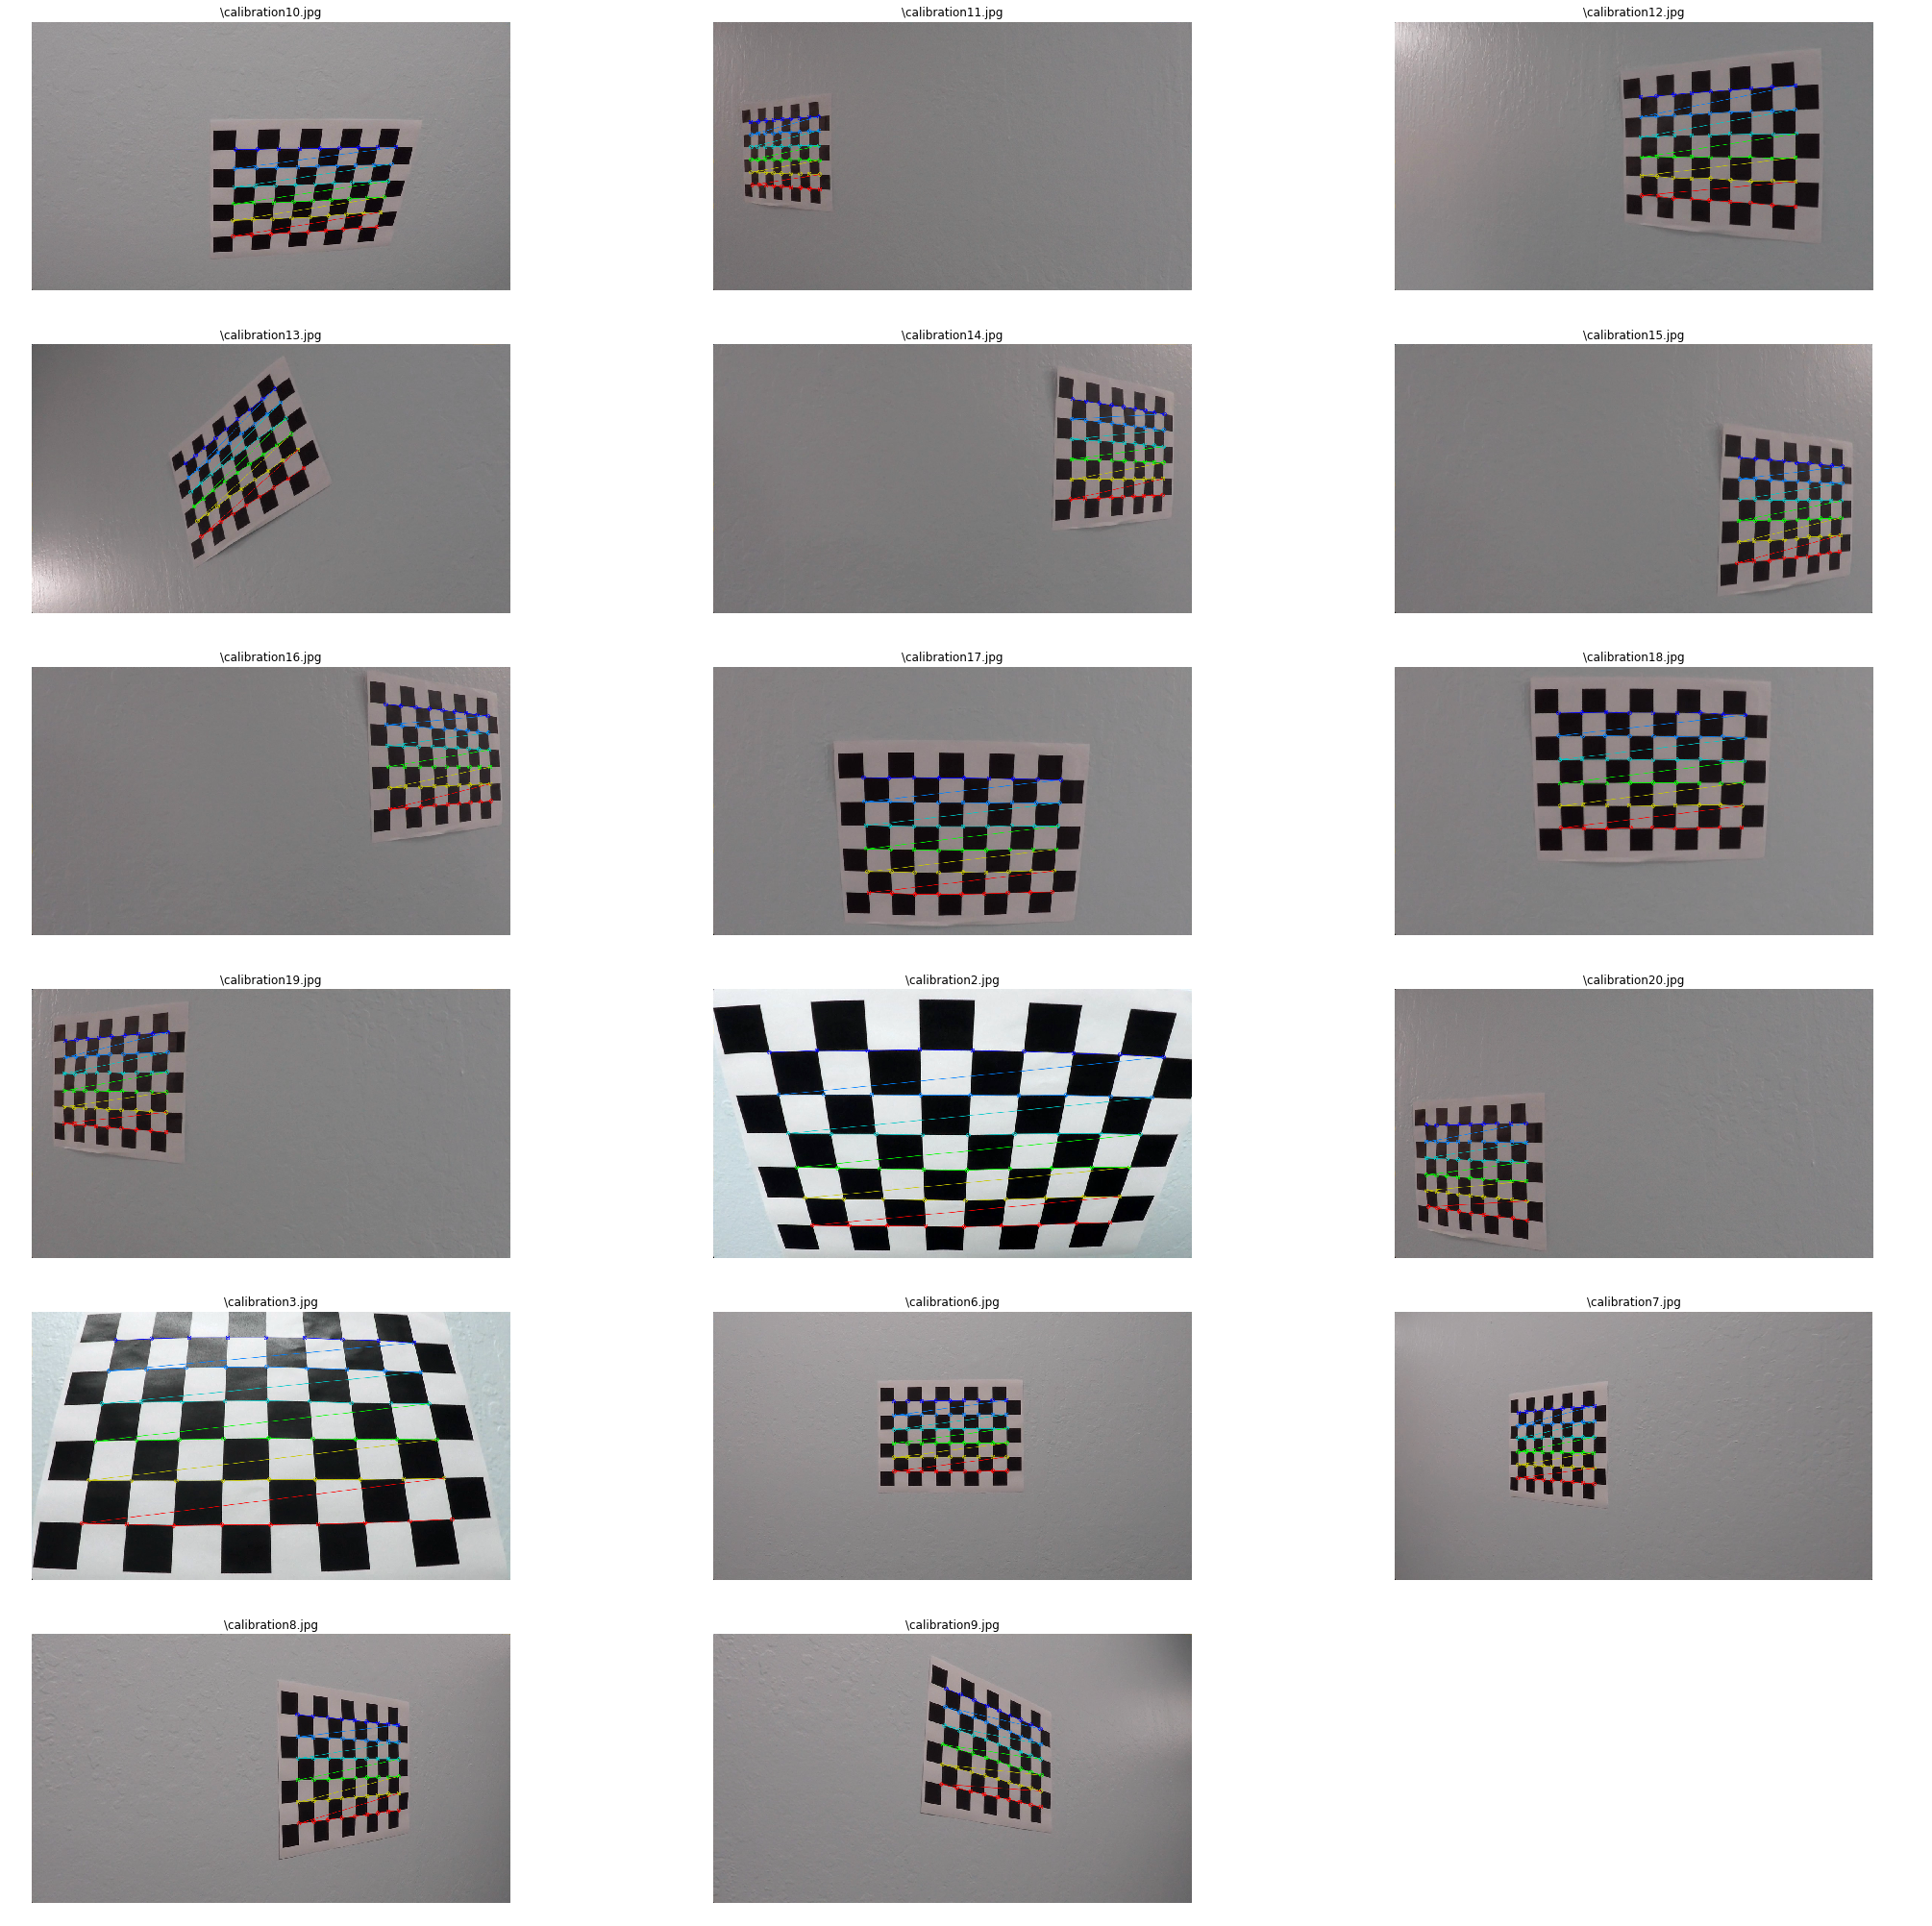

In [1]:
# Import required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
# Import pickle
%matplotlib inline

# Prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
nx = 9
ny = 6
objpoints = []
imgpoints = []

# Make a list of calibration images
test_pics = glob.glob('camera_cal/calibration*.jpg')

# Use j instead of index for setting image counter since some images do not have proper number of corners
j = 0

# Prepare axis
figure, axis = plt.subplots(6,3, figsize=(36, 36))

# This turns off the last image since we only have 17 valid images
axis[-1, -1].axis('off')

axis = axis.ravel()

for idx, fname in enumerate(test_pics):
    # Create the resulting image files
    img = cv2.imread(fname)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        axis[j].axis('off')
        img = img.squeeze()
        axis[j].set_title(fname.lstrip('camera_cal'))
        axis[j].imshow(img)
        
        j += 1
        
# Calibrate the camera using sample jpg and objpoints/imgpoints calculated above
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


Undistorting a test image


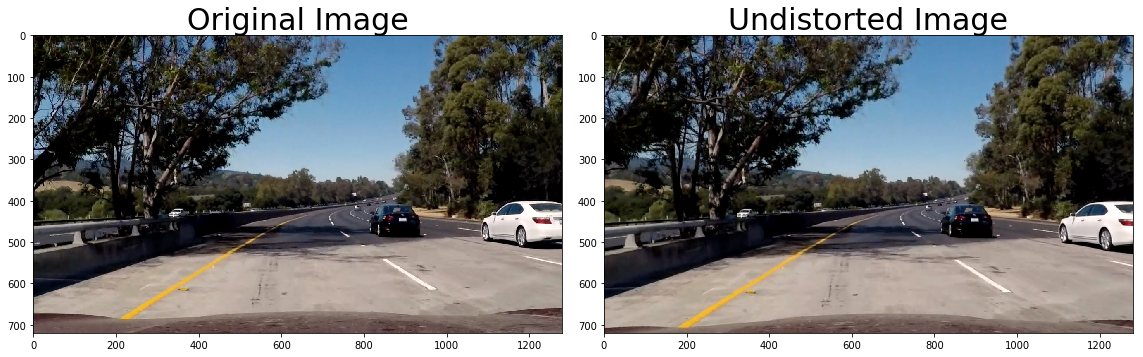

In [2]:
def undistor(image): 
    # Undistorting a test image
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst

# Display the original and an undistorted image sample
print('Undistorting a test image')
image_file = 'test_images/test5.jpg'
img = cv2.imread(image_file)
img = img[...,::-1]  # RGB -> BGR  
undist = undistor(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.tight_layout()
ax1.set_title("Original Image", fontsize=30)
ax1.imshow(img)
ax2.set_title("Undistorted Image", fontsize=30)
ax2.imshow(undist)

## General Functions

In [3]:
# Color threshold function
def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1
    
    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    return output

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))   
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1

    return output

def get_warped(bimage):
    img_size = (bimage.shape[1],bimage.shape[0])
    
    offset = 350

    # Source points
    src = np.float32([[[ 610,  450]], 
                      [[ 680,  450]], 
                      [[ 980,  680]],
                      [[ 380,  680]]])

    # Result points        
    dst = np.float32([[offset, 0], 
                    [img_size[0]-offset, 0], 
                    [img_size[0]-offset, img_size[1]], 
                    [offset, img_size[1]]])  
 
    return_perspective_M = cv2.getPerspectiveTransform(src,dst)

    return_warped = cv2.warpPerspective(bimage, return_perspective_M, img_size,flags=cv2.INTER_LINEAR)

    return return_perspective_M, return_warped



## Find Lane Lines Functions

In [4]:
# Class that will find lanes on the image
class tracker():
    def __init__(self, Mywindow_width, Mywindow_height, Mymargin, Mysmooth_factor=15):

        self.recent_centers = []
        self.window_width = Mywindow_width
        self.window_height = Mywindow_height
        self.margin = Mymargin
        self.smooth_factor = Mysmooth_factor
        
    def find_window_centroids(self, image):
        window_width = self.window_width
        window_height = self.window_height
        margin = self.margin

        window_centroids = [] # Store the left/right window centroid positions per level
        window = np.ones(window_width)
        
        l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)

        # Append the left and right center to window_centroids
        window_centroids.append((l_center, r_center))

        for level in range(1,(int)(image.shape[0]/window_height)):
            image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:],axis=0)
            conv_signal = np.convolve(window, image_layer)
            
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,image.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,image.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset

            window_centroids.append((l_center,r_center))
    
        self.recent_centers.append(window_centroids)
        # Smooth the lines and return
        return np.average(self.recent_centers[-self.smooth_factor:], axis=0)

def curve(leftx, rightx):
    # Fit the lane boundaries to the left, right center positions
    yvals = np.linspace(0, 719, num=9)
    
    # Reverse to match top-to-bottom in y
    leftx = np.asarray(leftx[::-1])  
    rightx = np.asarray(rightx[::-1])
    
    left_fit = np.polyfit(yvals, leftx, 2)
    left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    right_fit = np.polyfit(yvals, rightx, 2)
    right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]

    position = ((rightx_int+leftx_int)/2)-50
    center = abs(640 - ((rightx_int+leftx_int)/2))
    
    y_eval = np.max(yvals)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(yvals*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(yvals*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    curve_fit_cr = np.polyfit(np.array(yvals,np.float32)*ym_per_pix, np.array(leftx,np.float32)*xm_per_pix,2)
    curverad = ((1 + (2*curve_fit_cr[0]*yvals[-1]*ym_per_pix + curve_fit_cr[1])**2)**1.5) / np.absolute(2*curve_fit_cr[0])
        
    return position, center, leftx, rightx, left_fitx, right_fitx, left_curverad, right_curverad, curve_fit_cr, curverad 
 

## Main Pipeline

In [5]:
# process the images
# note that this will be used both for static images as well as video
def process_image(img):
    # Use dark background for various plt
    plt.style.use(['dark_background'])

    #undistort the image
    img = cv2.undistort(img,mtx,dist,None,mtx)    
  
    # Apply sobel threshold
    preprocessImage = np.zeros_like(img[:,:,0])
    gradx = abs_sobel_thresh(img, orient='x', thresh=(12,255)) # 12
    grady = abs_sobel_thresh(img, orient='y', thresh=(25,255)) # 25

    # Apply color threshold
    c_binary = color_threshold(img, sthresh=(100,255), vthresh=(50,255))
    preprocessImage[((gradx == 1) & (grady == 1) | (c_binary == 1))] = 255
   
    # We now have a binary image to use
    binary_image = preprocessImage
        
    if is_video == False:
        write_name = 'test_images/binary'+str(idx)+'.jpg'
        cv2.imwrite(write_name, binary_image)

    # Warp the original image. For display only, will not be processed further    
    perspective_M_orig, warped_orig = get_warped(img)
    write_name = 'test_images/warped_reg'+str(idx)+'.jpg'
    cv2.imwrite(write_name,warped_orig)  
    
    # Warp the binary image
    perspective_M, warped = get_warped(binary_image)
    
    if is_video == False:
        write_name = 'test_images/warped_bin'+str(idx)+'.jpg'
        cv2.imwrite(write_name,warped) 

    # Set the window width/height and margin
    window_width = 50 
    window_height = 80 # Break image into 9 vertical layers since image height is 720
    margin = 100 # How much to slide left and right for searching

    # Find lanes
    curve_centers = tracker(Mywindow_width = window_width, Mywindow_height = window_height, Mymargin = margin)
    window_centroids = curve_centers.find_window_centroids(warped)
    
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)
    
    rightx = []
    leftx = []

    # Loop through the window centroids and apply the mask
    for level in range(0,len(window_centroids)):
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        leftx.append(window_centroids[level][0])
        rightx.append(window_centroids[level][1])
        
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    out_img = np.dstack((warped, warped, warped))*255
    warpage = np.array(out_img,np.uint8)
    result = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) 

    if is_video == False:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
        f.tight_layout()
        ax1.set_title("Warped Image", fontsize=30)
        ax1.imshow(warped)
        ax2.set_title("Fitted image", fontsize=30)
        ax2.imshow(result)
    
    # Determine curves
    position, center, leftx, rightx, left_fitx, right_fitx, left_curverad, right_curverad, curve_fit_cr, curverad  = curve(leftx, rightx)

    
    # Inverse perspective
    Minv = np.linalg.inv(perspective_M)

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    yvals = np.linspace(0, 719, num=9)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,200,0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Calculate center
    camera_center = (left_fitx[-1] + right_fitx[-1])/2
    center_diff = (camera_center-result.shape[1]/2)*xm_per_pix
    side_pos = 'left'
    if center_diff <= 0:
        side_pos = 'right'
        
    if is_video == False:
        cv2.putText(result,'Radius of Curvature = ' + str(round(curverad,3))+'(m)',(50,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
        cv2.putText(result,'Vehicle is ' + str(abs(round(center_diff,3)))+'m '+side_pos+' of center',(50,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)

        write_name = 'test_images/fit'+str(idx)+'.jpg'
        cv2.imwrite(write_name, result)
        mark_size = 3
        temp = 611 + idx

        plt.figure(1)
        plt.figure(figsize=(5,20),facecolor='black', edgecolor='black')
        plt.subplot(temp)

        plt.xlim(0, 1280)
        plt.ylim(0, 720)

        plt.plot(left_fitx, yvals, color='red', linewidth=3)
        plt.plot(right_fitx, yvals, color='blue', linewidth=3) 
        
        write_name = 'test_images/final'+str(idx)+'.jpg'
        cv2.imwrite(write_name, result)  
    
    return result

## Process the Test Images

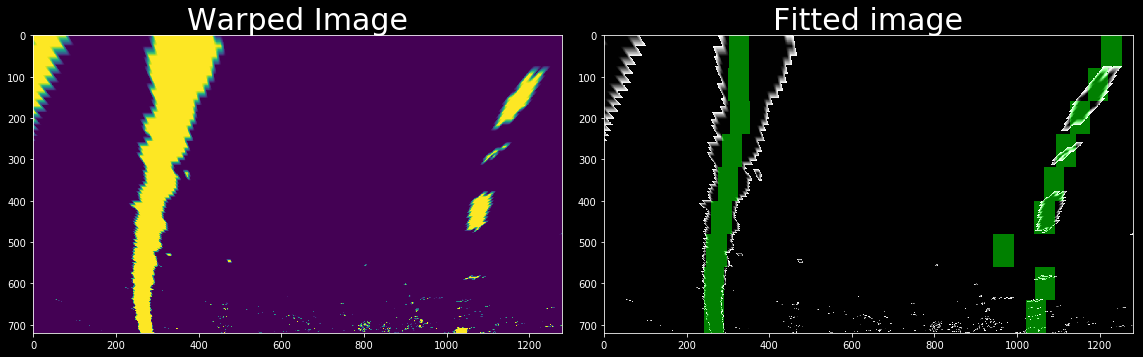

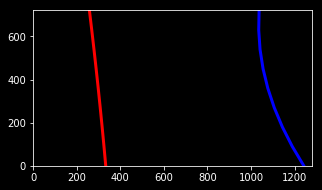

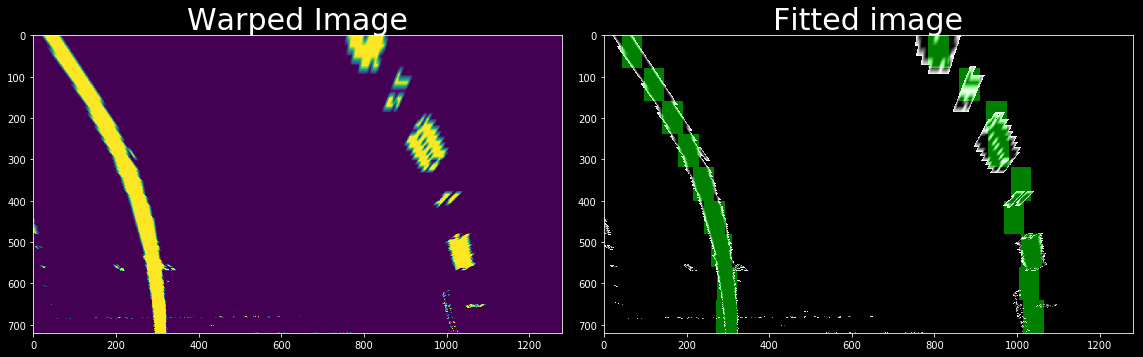

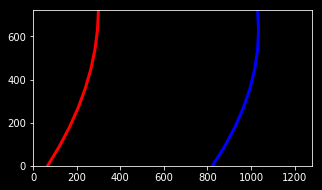

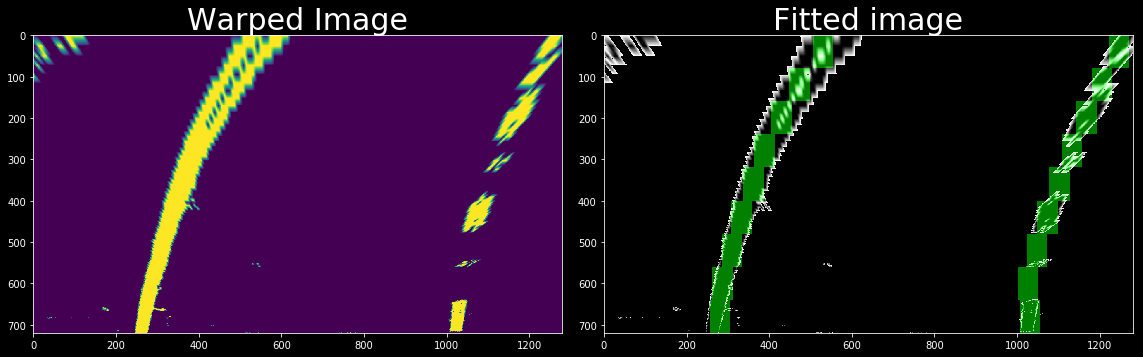

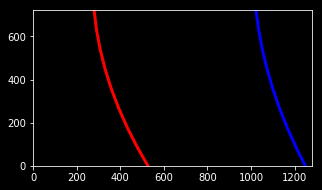

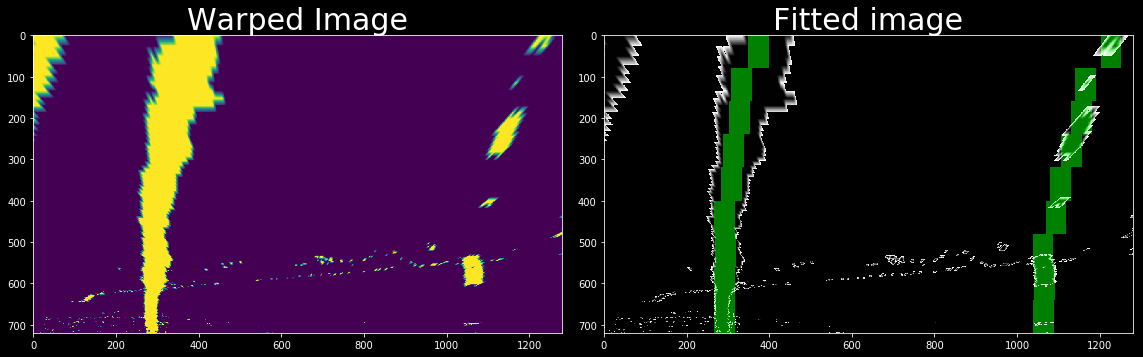

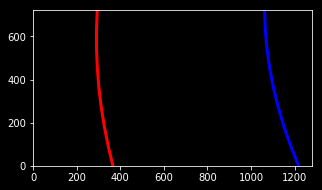

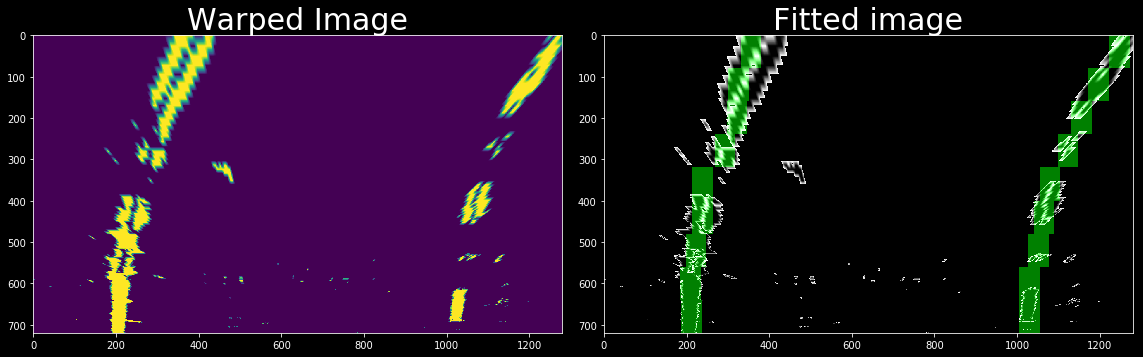

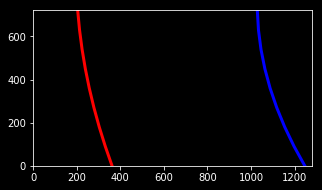

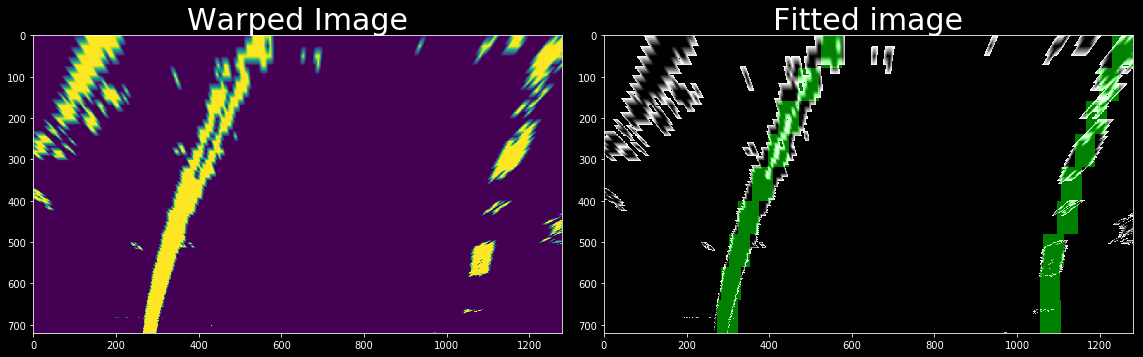

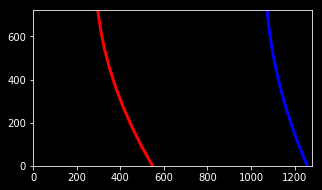

In [6]:
# To be used for processing jpg images
test_pics = glob.glob('test_images/test*.jpg')
is_video = False

for idx, fname in enumerate(test_pics):
    image_input = cv2.imread(fname)
    process_image(image_input)

## Process the Video

In [7]:
# To be used for processing jpg images
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML

is_video = True

Output_video = 'output1_tracked.mp4'
Input_video = 'project_video.mp4'

clip1 = VideoFileClip(Input_video)

video_clip = clip1.fl_image(process_image)
video_clip.write_videofile(Output_video, audio=False, progress_bar=True)


[MoviePy] >>>> Building video output1_tracked.mp4
[MoviePy] Writing video output1_tracked.mp4


100%|█████████████████████████████████████▉| 1260/1261 [17:55<00:00,  1.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output1_tracked.mp4 

